# **Cat vs Dogs Image Classification**

## **Import Dependencies**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from glob import glob
import torch
from torch import nn
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchmetrics import Accuracy
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = "Times New Roman"

torch.__version__

'2.4.0'

## **Read the Data**

In [2]:
# Store all the image paths inside a variable
image_paths = glob(r"/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/*/*.jpg")
print("Total number of images:", len(image_paths))

# Print the size of five random images
random.seed(42)
for f in range(5):
    img = cv2.imread(random.choice(image_paths))
    print(img.shape)

Total number of images: 25000
(318, 480, 3)
(357, 400, 3)
(300, 400, 3)
(187, 250, 3)
(400, 500, 3)


In [3]:
# Split the file paths into train and test set
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
print("Number of training images:", len(train_paths))
print("Number of testing images:", len(test_paths))

Number of training images: 20000
Number of testing images: 5000


In [4]:
# Write a helper function to prepare images
def prepare_images(image_paths, size, labels):
    # Store all the images and labels into seperate arrays
    X, y = [], []
    
    # Preapare testings images and labels
    for f in tqdm(image_paths, desc="Preparing images..."):
        try:
            img = plt.imread(f) # reading the image
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # transforming from BGR to RGB
            img_resized = cv2.resize(img, (size, size)) # Resizing the image

            if img_resized.shape == (SIZE, SIZE, 3):
                X.append(img_resized)
                label_str = f.split("/")[-2].lower()
                y.append(labels[label_str])

            else:
                continue
    
        except:
            continue

    return np.array(X, dtype=np.uint8), np.array(y, dtype=np.uint8)

In [5]:
# Define the image size parameters
SIZE = 128
LABELS = {"cat": 0, "dog": 1}

# Store all the images into arrays
X_train, y_train = prepare_images(train_paths, size=SIZE, labels=LABELS)
X_test, y_test = prepare_images(test_paths, size=SIZE, labels=LABELS)

print(X_train.shape, X_test.shape)

Preparing images...: 100%|██████████| 5000/5000 [00:42<00:00, 117.79it/s]


(19937, 128, 128, 3) (4994, 128, 128, 3)


In [6]:
# Convert the channel last to channel first
X_train, X_test = np.transpose(X_train, (0, 3, 1, 2)), np.transpose(X_test, (0, 3, 1, 2))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19937, 3, 128, 128) (4994, 3, 128, 128) (19937,) (4994,)


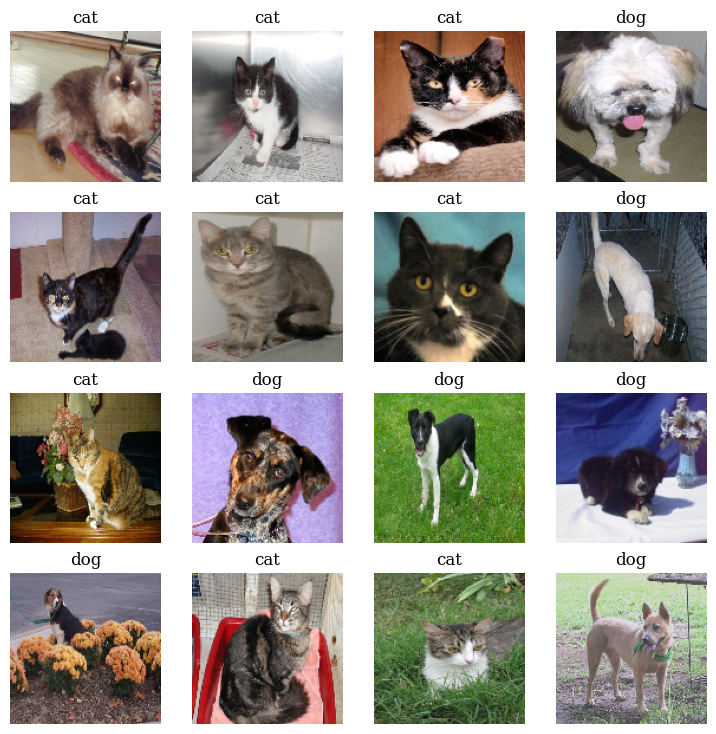

In [7]:
# Plot some random images from the training data
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_id = random.randint(0, X_train.shape[0])
    X, y = X_train[random_id], y_train[random_id]
    fig.add_subplot(rows, cols, i)
    plt.imshow(np.transpose(X, (1, 2, 0)))
    plt.title([key for key, value in LABELS.items() if y==value][0])
    plt.axis(False)

In [8]:
# Convert the data into tensors
X_train, y_train = torch.from_numpy(X_train).type(torch.float), torch.from_numpy(y_train).type(torch.LongTensor)
X_test, y_test = torch.from_numpy(X_test).type(torch.float), torch.from_numpy(y_test).type(torch.LongTensor)

# Apply normalization
X_train, X_test = X_train/255, X_test/255
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([19937, 3, 128, 128]),
 torch.Size([4994, 3, 128, 128]),
 torch.Size([19937]),
 torch.Size([4994]))

## **Build the Model (VGG-16) using PyTorch**

**Model Architecture:**<br>
<img src="https://miro.medium.com/v2/resize:fit:1400/1*VPm-hHOM14OisbFUU4cL6Q.png" width="60%">

In [9]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [34]:
# Build the VGG-16 architecture
class VGG16(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super().__init__()
        
        # First block
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Second block
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Third block
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fourth block
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fifth block
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Final linear block and the classifier
        self.linear_block_6 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4*4*512, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, X: torch.Tensor):
        X = self.conv_block_1(X)
        X = self.conv_block_2(X)
        X = self.conv_block_3(X)
        X = self.conv_block_4(X)
        X = self.conv_block_5(X)
        X = self.linear_block_6(X)
        return X

In [67]:
# Create an instance of VGG-16 model
torch.manual_seed(42)

model = VGG16(in_channels=3, num_classes=2).to(device)
model

VGG16(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
   

In [68]:
# Setup the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.005, momentum=0.9)

# Setup the accuracy function using torchmetrics
accuracy_fn = Accuracy(task="binary", num_classes=2).to(device)

In [69]:
# Prepare dataloaders
BATCH_SIZE = 32
train_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 624 batches of 32
Length of test dataloader: 157 batches of 32


In [70]:
# Start the training loop
torch.manual_seed(42)

# Define the epochs
EPOCHS = 10

# Store all the history in a dictionary
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

highest_test_acc = 0
best_model_path = "best_model.pth" 

for epoch in range(EPOCHS):
    print(f"Epoch: {epoch} | ", end="")
    
    ## Training
    train_avg_loss, train_avg_acc = 0.0, 0.0
    
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        # Set the model in training model
        model.train()
        
        # Perform the steps
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_avg_loss += loss.item()

        # Calculate accuracy
        acc = accuracy_fn(y_pred.argmax(dim=1), y).item()
        train_avg_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Divide total train_avg_loss, train_avg_acc by the length of the train dataloader
    train_avg_loss /= len(train_dataloader)
    train_avg_acc /= len(train_dataloader)

    # Testing
    test_avg_loss, test_avg_acc = 0.0, 0.0
    model.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss = loss_fn(test_pred, y).item()
            test_avg_loss += test_loss
            
            test_acc = accuracy_fn(test_pred.argmax(dim=1), y).item()
            test_avg_acc += test_acc

    # Divide the test_avg_loss and test_avg_acc by length of test dataloader
    test_avg_loss /= len(test_dataloader)
    test_avg_acc /= len(test_dataloader)

    # Print out training and testing results
    history["epoch"].append(epoch)
    history["train_loss"].append(train_avg_loss)
    history["train_acc"].append(train_avg_acc)
    history["test_loss"].append(test_avg_loss)
    history["test_acc"].append(test_avg_acc)

    print(f"Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_avg_acc:.4f} | ", end="")
    print(f"Test Loss: {test_avg_loss:.4f}, Test Accuracy: {test_avg_acc:.4f}")

    # Save the model if test accuracy is the lowest
    if test_avg_acc > highest_test_acc:
        highest_test_acc = test_avg_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"*** Model saved with highest test accuracy: {highest_test_acc:.4f} ***")

Epoch: 0 | *** Model saved with highest test accuracy: 0.7866 ***
Train Loss: 0.5562, Train Accuracy: 0.7063 | Test Loss: 0.4522, Test Accuracy: 0.7866
Epoch: 1 | *** Model saved with highest test accuracy: 0.8453 ***
Train Loss: 0.3844, Train Accuracy: 0.8253 | Test Loss: 0.3389, Test Accuracy: 0.8453
Epoch: 2 | *** Model saved with highest test accuracy: 0.8796 ***
Train Loss: 0.2741, Train Accuracy: 0.8841 | Test Loss: 0.2921, Test Accuracy: 0.8796
Epoch: 3 | *** Model saved with highest test accuracy: 0.8997 ***
Train Loss: 0.2061, Train Accuracy: 0.9158 | Test Loss: 0.2360, Test Accuracy: 0.8997
Epoch: 4 | Train Loss: 0.1696, Train Accuracy: 0.9321 | Test Loss: 0.5649, Test Accuracy: 0.7685
Epoch: 5 | Train Loss: 0.1727, Train Accuracy: 0.9295 | Test Loss: 0.2824, Test Accuracy: 0.8784
Epoch: 6 | *** Model saved with highest test accuracy: 0.9082 ***
Train Loss: 0.1136, Train Accuracy: 0.9560 | Test Loss: 0.2331, Test Accuracy: 0.9082
Epoch: 7 | *** Model saved with highest test a

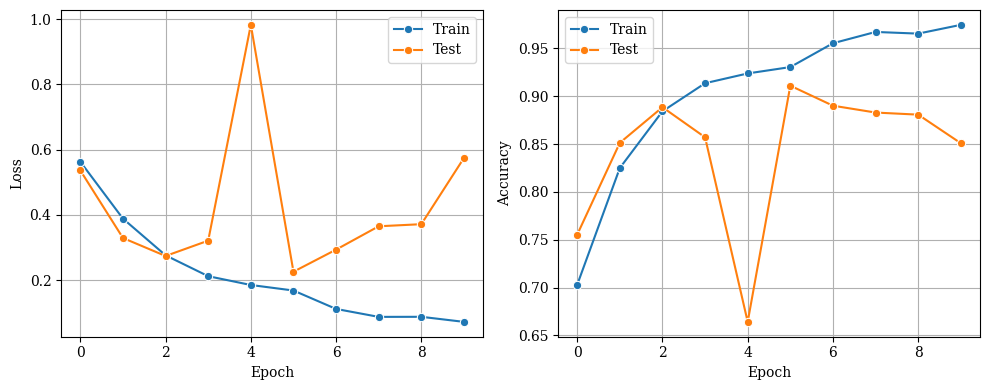

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes = axes.flatten()

sns.lineplot(x=history["epoch"], y=history["train_loss"], label="Train", ax=axes[0], marker="o")
sns.lineplot(x=history["epoch"], y=history["test_loss"], label="Test", ax=axes[0], marker="o")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid()

sns.lineplot(x=history["epoch"], y=history["train_acc"], label="Train", ax=axes[1], marker="o")
sns.lineplot(x=history["epoch"], y=history["test_acc"], label="Test", ax=axes[1], marker="o")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].grid()

plt.tight_layout();